In [1]:
from mlp import MLP
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
%matplotlib inline
data, label = make_moons(n_samples=1000, noise=0.2)

Using Theano backend.
/home/aulloa/.virtualenvs/p3/lib/python3.4/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/home/aulloa/.virtualenvs/p3/lib/python3.4/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(1000, 2)
(1000,)


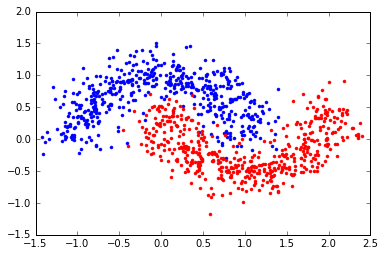

In [2]:
print(data.shape)
print(label.shape)

plt.plot(data[label==0,0], data[label==0,1],'.')
plt.plot(data[label==1,0], data[label==1,1],'r.')

# Using MLP with sklearn's cross_val_score

In [3]:

from sklearn.cross_validation import cross_val_score

clf = MLP(n_hidden=10, n_deep=3, l1_norm=0, drop=0.1, verbose=0)

scores = cross_val_score(clf, data, label, cv=5, n_jobs=1, scoring='roc_auc')
print(scores)

[ 0.9932  0.9906  0.9951  0.9639  0.9885]


# Using MLP with sklearn's GridSearchCV

In [ ]:
from sklearn.grid_search import GridSearchCV

params = {'n_hidden': [10, 15], 
         'l1_norm': [0.0],
         'n_deep': [2, 3],
         'drop': [0.1]}

clf_grid = GridSearchCV(clf, param_grid=params, scoring='roc_auc', cv=5, n_jobs=1)
scores = cross_val_score(clf_grid, data, label, cv=5, n_jobs=1, scoring='roc_auc')
print(scores)

# Extracting layer representation

In [6]:
clf = MLP(n_hidden=10, n_deep=3, l2_norm=1, drop=0.1, verbose=0, early_stop=False)
clf.fit(data, label)
layers = clf.feed_forward(data)

[(1000, 10), (1000, 5), (1000, 2), (1000, 1)]


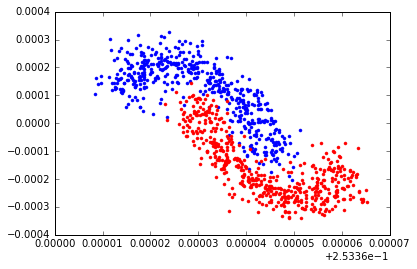

In [7]:
print([layer.shape for layer in layers])

plt.plot(layers[2][label==0,0], layers[2][label==0,1],'.')
plt.plot(layers[2][label==1,0], layers[2][label==1,1],'r.')

# Simple training and history plotting

In [ ]:
from sklearn.cross_validation import StratifiedKFold

kf = StratifiedKFold(label, n_folds=5, shuffle=True, random_state=1988)
kf = list(kf)
train, test = kf[0]
clf = MLP(n_hidden=10, n_deep=3, l2_norm=0.01, l1_norm=0.01, drop=0.1, verbose=0, early_stop=False)
clf.fit(data[train,:], label[train])
clf.auc(data[train,:], label[train])

dict_keys(['size', 'batch', 'loss'])


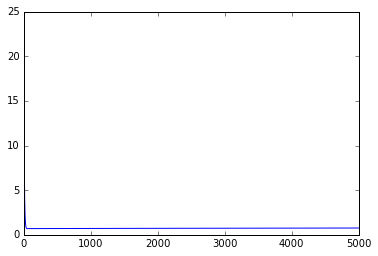

In [9]:
print(clf.hist.history.keys())
#plt.plot(clf.hist.history['val_loss'])
plt.plot(clf.hist.history['loss'])
#plt.plot(clf.hist.history['size'])
#plt.plot(clf.hist.history['batch'])